In [1]:
import network
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from sklearn.manifold import TSNE

In [2]:
IMAGE_DIM = 100
WHM_ph = tf.placeholder(tf.float32,[None,IMAGE_DIM*IMAGE_DIM])
BMC_ph = tf.placeholder(tf.float32,[None,IMAGE_DIM*IMAGE_DIM])
is_training = tf.placeholder(tf.bool)

In [3]:
def read_and_decode(filename, batch_size):
    # first construct a queue containing a list of filenames.
    # this lets a user split up there dataset in multiple files to keep
    # size down
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)
    # Unlike the TFRecordWriter, the TFRecordReader is symbolic
    reader = tf.TFRecordReader()
    # One can read a single serialized example from a filename
    # serialized_example is a Tensor of type string.
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted backimport matplotlib.pyplot as plt
    #%matplotlib inlineto actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'image': tf.FixedLenFeature([IMAGE_DIM*IMAGE_DIM], tf.float32),
            'disease_label': tf.FixedLenFeature([4], tf.float32),
            'file_name': tf.FixedLenFeature([],tf.string)
        })
    # now return the converted data
    image = features['image']
    label = features['disease_label']
    file_name = features['file_name']
    
    # groups examples into batches randomly
    batch = tf.train.shuffle_batch([image, label, file_name], batch_size=batch_size,
                                          capacity=batch_size*5, min_after_dequeue=batch_size)
    
    return batch

In [4]:
model = network.Network('model', BMC_ph, WHM_ph, [IMAGE_DIM,IMAGE_DIM], is_training)

In [5]:
# LS GAN loss
DB_loss = 0.5 * (tf.reduce_mean((model.dB_real - 1)**2) + tf.reduce_mean(model.dB_fake**2))

DA_loss = 0.5 * (tf.reduce_mean((model.dA_real - 1)**2) + tf.reduce_mean(model.dA_fake**2))

cycle_loss = tf.reduce_mean(tf.norm(tf.abs(BMC_ph - tf.reshape(model.reconstruct_A, [-1,IMAGE_DIM*IMAGE_DIM])),axis=1)) + \
             tf.reduce_mean(tf.norm(tf.abs(WHM_ph - tf.reshape(model.reconstruct_B, [-1,IMAGE_DIM*IMAGE_DIM])),axis=1))

GB_loss = 10 * tf.reduce_mean((model.dB_fake - 1)**2) + 2*cycle_loss

GA_loss = 10 * tf.reduce_mean((model.dA_fake - 1)**2) + 2*cycle_loss

In [6]:
def make_optimiser(loss, variables,name, optimiser = 'Adam', beta1 = 0.5,learning_rate = 2e-4):
    """ 
    Make an optimiser with initial given learning rate that stays constant for the first 100 epochs
    and decays linearly afterwards
    """
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = learning_rate
    end_learning_rate = 0.0
    start_decay_step = 100000
    decay_steps = 100000
    
    # make the learning rate that is constant initially, and then linearly decreases after
    # start_decay_step
    learning_rate = (
          tf.where(
                  tf.greater_equal(global_step, start_decay_step),
                  tf.train.polynomial_decay(starter_learning_rate, global_step-start_decay_step,
                                            decay_steps, end_learning_rate,
                                            power=1.0),
                  starter_learning_rate
          )
      )
    if optimiser == 'Adam':
        learning_step = tf.train.AdamOptimizer(learning_rate, beta1=beta1,name=name).minimize(loss, global_step=global_step, var_list=variables)

    elif optimiser == 'SGD':
        learning_step = tf.train.GradientDescentOptimizer(learning_rate,name=name).minimize(loss, global_step=global_step, var_list=variables)
    
    return learning_step

In [7]:
genB_optimiser = make_optimiser(GB_loss, model.get_GB_params(),'Adam_genB')
dB_optimiser = make_optimiser(DB_loss, model.get_DB_params(),'Adam_dB')
genA_optimiser = make_optimiser(GA_loss, model.get_GA_params(), 'Adam_genA')
dA_optimiser = make_optimiser(DA_loss, model.get_DA_params(), 'Adam_dA')

In [8]:
#with tf.control_dependencies([genB_optimiser, genA_optimiser]):
#    gen_optimisers = tf.no_op(name='gen_optimisers')

#with tf.control_dependencies([dB_optimiser, dA_optimiser]):
#    discrim_optimisers = tf.no_op(name='discrim_optimisers')

with tf.control_dependencies([genB_optimiser, genA_optimiser, dB_optimiser, dA_optimiser]):
    optimisers = tf.no_op(name='optimisers')

In [9]:
# build some summary statistics on tensorboard
tf.summary.histogram('dB/true', model.dB_real)
tf.summary.histogram('dB/fake', model.dB_fake)
# build some summary statistics on tensorboard
tf.summary.histogram('dA/true', model.dA_real)
tf.summary.histogram('dA/fake', model.dA_fake)


tf.summary.scalar('loss/genB', GB_loss)
tf.summary.scalar('loss/dB', DB_loss)
tf.summary.scalar('loss/genA', GA_loss)
tf.summary.scalar('loss/dA', DA_loss)
tf.summary.scalar('loss/cycle', cycle_loss)

tf.summary.image('image/genB_train', model.genB, max_outputs=2)
tf.summary.image('image/genBtoA_train', model.reconstruct_A, max_outputs=2)
#tf.summary.image('image/WHM_generator_out',model.original,max_outputs=2)
tf.summary.image('image/BMC_train',tf.reshape(BMC_ph,[-1,IMAGE_DIM,IMAGE_DIM,1]),max_outputs=2)
tf.summary.image('image/WHM_train',tf.reshape(WHM_ph,[-1,IMAGE_DIM,IMAGE_DIM,1]),max_outputs=2)

summary_op = tf.summary.merge_all()

In [10]:
# Initialize an saver for store model checkpoints
saver = tf.train.Saver()

In [11]:
checkpoints_dir = 'scaled_model/scale_-1_1_instance'
checkpoints_path = checkpoints_dir + '/checkpoints'
if not os.path.exists(checkpoints_path):
    os.makedirs(checkpoints_path)

# Restoring the model

We test the differences between the canonical brain and its transformation through the different generator

In [12]:
import nibabel as nib

In [13]:
epi_img = nib.load('mwc1colin27_t1_tal_lin.nii')
img_data = epi_img.get_data()

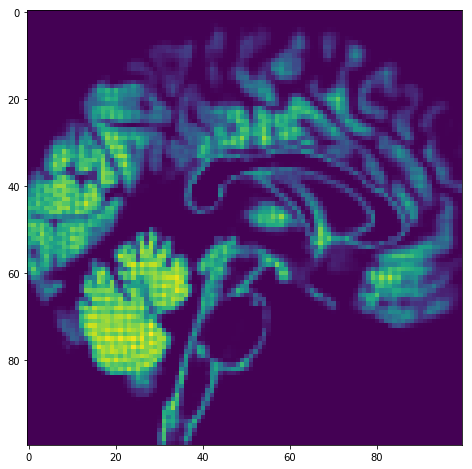

In [14]:
plt.figure(figsize=(8,8))
slice_data = img_data[60,20:120,:100]
plt.imshow(np.rot90(slice_data))

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.restore(sess,tf.train.latest_checkpoint(checkpoints_path))

INFO:tensorflow:Restoring parameters from scaled_model/scale_-1_1_instance/checkpoints/model_epoch0.ckpt


In [16]:
# transform the BMC dataset
MNI_to_WHM = sess.run(model.genB, feed_dict={BMC_ph: np.reshape(slice_data, (1, IMAGE_DIM*IMAGE_DIM)),
                                                      is_training: False})

MNI_to_BMC = sess.run(model.genA, feed_dict={WHM_ph: np.reshape(slice_data, (1, IMAGE_DIM*IMAGE_DIM)),
                                                      is_training: False})

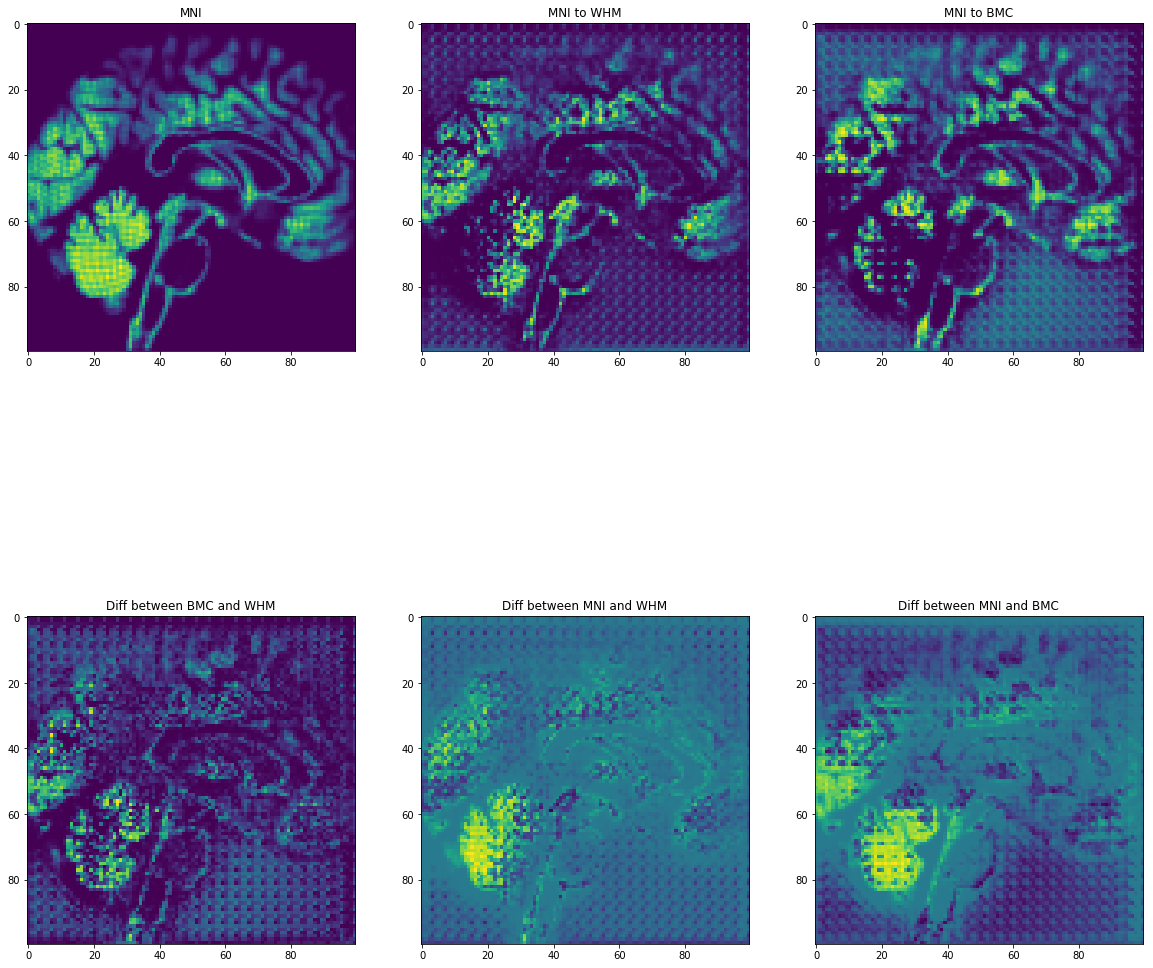

In [17]:
plt.figure(figsize=(20,20))
plt.subplot(231)
plt.imshow(np.rot90(slice_data))
plt.title('MNI')
plt.subplot(232)
plt.imshow(np.rot90(np.reshape(MNI_to_WHM, (IMAGE_DIM, IMAGE_DIM))))
plt.title('MNI to WHM')
plt.subplot(233)
plt.imshow(np.rot90(np.reshape(MNI_to_BMC, (IMAGE_DIM, IMAGE_DIM))))
plt.title('MNI to BMC')


plt.subplot(234)
plt.imshow(np.rot90(np.reshape(abs(MNI_to_WHM - MNI_to_BMC), (IMAGE_DIM, IMAGE_DIM))))
plt.title('Diff between BMC and WHM')

plt.subplot(235)
plt.imshow(np.rot90(abs(slice_data-np.reshape(MNI_to_WHM, (IMAGE_DIM, IMAGE_DIM)))))
plt.title('Diff between MNI and WHM')

plt.subplot(236)
plt.imshow(np.rot90(abs(slice_data-np.reshape(MNI_to_BMC, (IMAGE_DIM, IMAGE_DIM)))))
plt.title('Diff between MNI and BMC')

# Training a classifier

Lets train a classifier to see if we do not lose any important information after the transformation.
The idea is:
    1. train a classifier on original data distinguishing healthy and non healthy patients
    2. transform the BMC data to remove scanner differences
    3. use the same classifier on the new data to distinguish healthy and non healthy
    4. hope for the best

In [18]:
# load the data
BMC_batch = read_and_decode('BMC_sagittal_data_scale_minmax-1_1.tfrecords', 79)
WHM_batch = read_and_decode('WHM_sagittal_data_scale_minmax-1_1.tfrecords', 420)

In [19]:
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess,coord=coord)

# get the next batch
BMC_train_batch, WHM_train_batch= sess.run([BMC_batch, WHM_batch])

coord.request_stop()
coord.join(threads) 

In [24]:
# transform the BMC dataset
BMC_train_transform = sess.run(model.genB, feed_dict={BMC_ph: BMC_train_batch[0],
                                                      is_training: False})

In [26]:
WHM_train_reconstruct = np.zeros((420,IMAGE_DIM,IMAGE_DIM,1))
for i in range(0,420,10):
    WHM_train_reconstruct[i:i+10] = sess.run(model.reconstruct_B, feed_dict={WHM_ph: WHM_train_batch[0][i:i+10],
                                                      is_training: False})

In [27]:
WHM_train_transform = np.zeros((420,IMAGE_DIM,IMAGE_DIM,1))
for i in range(0,420,10):
    WHM_train_transform[i:i+10] = sess.run(model.genA, feed_dict={WHM_ph: WHM_train_batch[0][i:i+10],
                                                      is_training: False})

In [28]:
disease_labels = np.concatenate((BMC_train_batch[1], WHM_train_batch[1]), axis=0)
original_data = np.concatenate((BMC_train_batch[0], WHM_train_batch[0]), axis=0)
BMC_transformed_combined_data = np.concatenate((np.reshape(BMC_train_transform, (-1, IMAGE_DIM*IMAGE_DIM)), WHM_train_batch[0]), axis=0)
WHM_BMC_transformed_combined_data = np.concatenate((np.reshape(BMC_train_transform, (-1, IMAGE_DIM*IMAGE_DIM)), 
                                                    np.reshape(WHM_train_reconstruct, (-1, IMAGE_DIM*IMAGE_DIM))), axis=0)
WMH_transformed_combined_data = np.concatenate((BMC_train_batch[0], np.reshape(WHM_train_transform, (-1, IMAGE_DIM*IMAGE_DIM))), axis=0)

In [29]:
# assign labels to healthy patients
healthy_labels = np.zeros(499)
healthy_labels[disease_labels[:,0] == 1] = 1

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

In [31]:
def run_svm(data, labels, n_split=5, kernel='linear'):
    # shuffle the data
    shuffled_data, shuffled_labels = shuffle(data, labels)
    
    kf = KFold(n_splits=n_split)
    avg_accuracy = 0
    for train, test in kf.split(shuffled_data, shuffled_labels):
        X_train = shuffled_data[train]
        y_train = shuffled_labels[train]
        X_test = shuffled_data[test]
        y_test = shuffled_labels[test]
        clf = SVC(kernel=kernel)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        #print score
        avg_accuracy += score
    print "The accuracy is %0.2f" %(avg_accuracy/n_split)

In [32]:
scanner_labels = np.zeros(499)
scanner_labels[79:] = 1

In [34]:
(shuffled_original_data, shuffled_BMC_transformed_combined_data, 
 shuffled_WHM_BMC_transformed_combined_data, shuffled_WMH_transformed_combined_data, 
 shuffled_scanner, shuffle_disease) = shuffle(original_data, BMC_transformed_combined_data, WHM_BMC_transformed_combined_data,
                                              WMH_transformed_combined_data, scanner_labels, disease_labels)

In [49]:
def create_train_test(data, label, test_size=10):
    test = np.concatenate((data[label == 1][:test_size], data[label==0][:test_size]), axis=0)
    train = np.concatenate((data[label == 1][test_size:], data[label==0][test_size:]), axis=0)
    
    train_label = np.concatenate((label[label==1][10:], 
                               label[label==0][10:]), axis=0)
    test_label = np.concatenate((label[label==1][:10], 
                               label[label==0][:10]), axis=0)
    
    train, train_label = shuffle(train,train_label)
    test, test_label = shuffle(test,test_label)
    
    return train, test, train_label, test_label

In [50]:
(train_original, test_original, 
 train_original_label, test_original_label) = create_train_test(shuffled_original_data, shuffled_scanner)
(train_BMC, test_BMC,
 train_BMC_label, test_BMC_label) = create_train_test(shuffled_BMC_transformed_combined_data, shuffled_scanner)
(train_WHM_BMC, test_WHM_BMC ,
 train_WHM_BMC_label, test_WHM_BMC_label) = create_train_test(shuffled_WHM_BMC_transformed_combined_data, shuffled_scanner)
(train_WMH, test_WMH,
 train_WHM_label, test_WHM_label) = create_train_test(shuffled_WMH_transformed_combined_data, shuffled_scanner)

In [140]:
pca = PCA(n_components=1)
train_reduced_dim = pca.fit_transform(train_original)
clf = SVC(kernel='linear')
clf.fit(train_reduced_dim, train_original_label)
test_reduced_dim = pca.transform(test_original)
print clf.predict(test_reduced_dim)
print clf.score(test_reduced_dim, test_original_label)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]
0.5


In [221]:
pca = PCA(n_components=1)
train_reduced_dim = pca.fit_transform(train_BMC)
clf = SVC(C = 10, gamma = 0.08, kernel='linear')
clf.fit(train_reduced_dim, train_BMC_label)
test_reduced_dim = pca.transform(test_BMC)
print clf.predict(test_reduced_dim)
print clf.score(test_reduced_dim, test_BMC_label)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]
0.5


In [228]:
np.reshape(np.sign(np.dot(test_reduced_dim,clf.coef_.T)),(-1)) == test_BMC_label

array([False, False, False,  True,  True, False, False,  True,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False], dtype=bool)

In [229]:
np.sign(np.dot(test_reduced_dim,clf.coef_.T)),(-1)

(array([[-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.]]), -1)

In [225]:
test_BMC_label

array([ 0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.])

In [220]:
clf.intercept_

array([ 0.80324054])

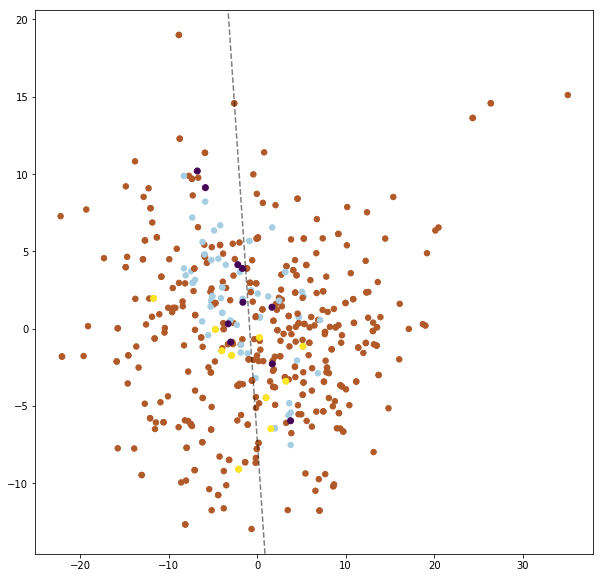

In [201]:
plt.figure(figsize=(10,10))
plt.scatter(train_reduced_dim[:, 0], train_reduced_dim[:, 1], c=train_BMC_label, s=30, cmap=plt.cm.Paired)
# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none')
plt.scatter(test_reduced_dim[:,0],test_reduced_dim[:,1],c=test_BMC_label)

In [114]:
pca = PCA(n_components=10)
train_reduced_dim = pca.fit_transform(train_WHM_BMC)
clf = SVC(kernel='rbf')
clf.fit(train_reduced_dim, train_WHM_BMC_label)
test_reduced_dim = pca.transform(test_WHM_BMC)
print clf.predict(test_reduced_dim)
print clf.score(test_reduced_dim, test_WHM_BMC_label)

[ 1.  1.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0.
  1.  1.]
0.8


In [115]:
pca = PCA(n_components=10)
train_reduced_dim = pca.fit_transform(train_WMH)
clf = SVC(kernel='rbf')
clf.fit(train_reduced_dim, train_WHM_label)
test_reduced_dim = pca.transform(test_WMH)
print clf.predict(test_reduced_dim)
print clf.score(test_reduced_dim, test_WHM_label)

[ 1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.  1.  1.  0.  1.  0.  1.
  1.  1.]
0.8


# Classify using SVM

We classify based on scanner using the original data

In [29]:
#pca = PCA(n_components=10000)
#reduced_dim = pca.fit_transform(original_data)
# test classification for scanner labels
run_svm(original_data, scanner_labels, n_split=10)

The accuracy is 0.99


In [30]:
# test classification for scanner labels
run_svm(original_data, healthy_labels, n_split=10)

The accuracy is 0.77


Using 10000 components, the svm was able to classify the scanner labels at 100% accuracy and the healthy and non healthy patients at 76%.

In [31]:
# perform and plot tsne of the slices
tsne = TSNE(n_components=2, perplexity=100.0, early_exaggeration=4.0, 
     learning_rate=1500.0, n_iter=2000, n_iter_without_progress=30, 
     min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0, random_state=None, 
     method='barnes_hut', angle=0.5)

# Visualing the transformed data

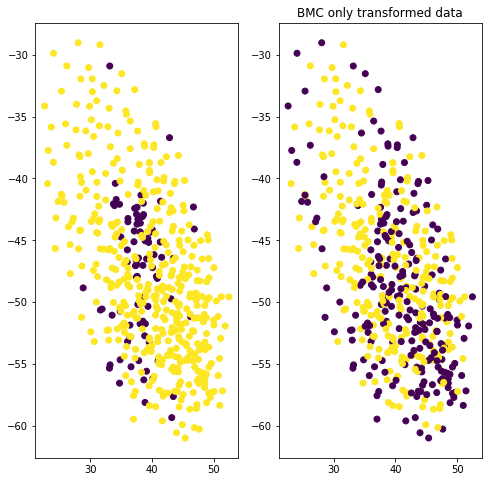

In [32]:
plt.figure(figsize=(8,8))
visualise_data = tsne.fit_transform(BMC_transformed_combined_data)
plt.subplot(121)
plt.scatter(visualise_data[:,0],visualise_data[:,1], c=scanner_labels)
plt.subplot(122)
plt.scatter(visualise_data[:,0],visualise_data[:,1], c=healthy_labels)
plt.title("BMC only transformed data")

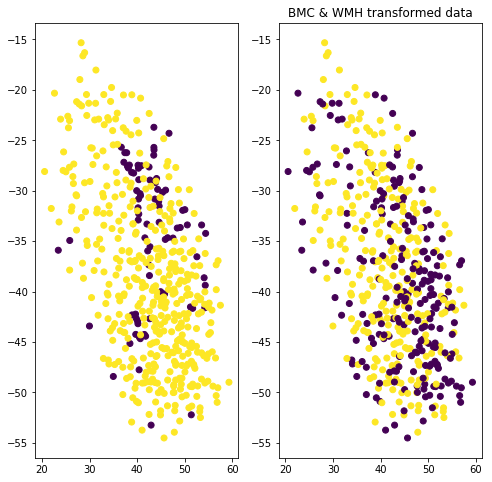

In [33]:
plt.figure(figsize=(8,8))
visualise_data = tsne.fit_transform(WHM_BMC_transformed_combined_data)
plt.subplot(121)
plt.scatter(visualise_data[:,0],visualise_data[:,1], c=scanner_labels)
plt.subplot(122)
plt.scatter(visualise_data[:,0],visualise_data[:,1], c=healthy_labels)
plt.title("BMC & WMH transformed data")

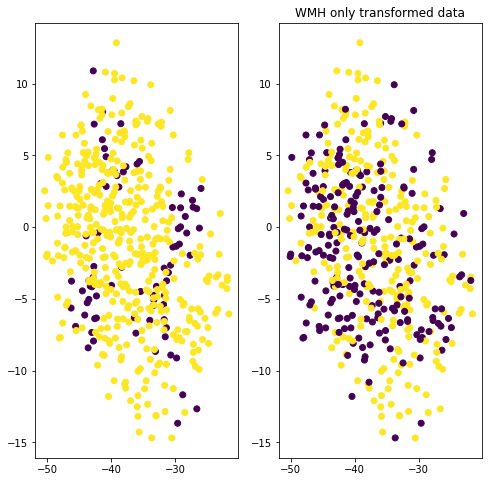

In [34]:
plt.figure(figsize=(8,8))
visualise_data = tsne.fit_transform(WMH_transformed_combined_data)
plt.subplot(121)
plt.scatter(visualise_data[:,0],visualise_data[:,1], c=scanner_labels)
plt.subplot(122)
plt.scatter(visualise_data[:,0],visualise_data[:,1], c=healthy_labels)
plt.title("WMH only transformed data")

# Perform SVM on transformed data

In [35]:
# run svm for transformed data
# see if it can classify healthy vs non healthy
#pca = PCA(n_components=10000)
#reduced_dim = pca.fit_transform(BMC_transformed_combined_data)
run_svm(BMC_transformed_combined_data, healthy_labels, n_split=10, kernel='linear')

The accuracy is 0.78


In [36]:
# classify scanner labels
#pca = PCA(n_components=10000)
#reduced_dim = pca.fit_transform(BMC_transformed_combined_data)
run_svm(BMC_transformed_combined_data, scanner_labels, n_split=10, kernel='linear')

The accuracy is 0.99


SVM is able to classify healthy vs non-healthy at 75% accurracy and between scanners at 100%

In [37]:
import pickle

#### Save weights of svm

In [38]:
clf = SVC(kernel='linear')
clf.fit(BMC_transformed_combined_data, scanner_labels)
weights_dict = {'weights': clf.coef_, 'biases': clf.intercept_}
pickle.dump(weights_dict, open("WMH_svm_weights.npy","w"))

In [40]:
run_svm(WMH_transformed_combined_data, scanner_labels, n_split=10, kernel='linear')

The accuracy is 0.98


In [41]:
clf = SVC(kernel='linear')
clf.fit(WMH_transformed_combined_data, scanner_labels)
weights_dict = {'weights': clf.coef_, 'biases': clf.intercept_}
pickle.dump(weights_dict, open("BMC_svm_weights.npy","w"))

### Transform both BMC and WMH

In [34]:
pca = PCA(n_components=10000)
reduced_dim = pca.fit_transform(WHM_BMC_transformed_combined_data)
run_svm(WHM_BMC_transformed_combined_data, scanner_labels, n_split=10, kernel='linear')

The accuracy is 0.98


In [35]:
pca = PCA(n_components=10000)
reduced_dim = pca.fit_transform(WHM_BMC_transformed_combined_data)
run_svm(WHM_BMC_transformed_combined_data, healthy_labels, n_split=10, kernel='linear')

The accuracy is 0.78
